# Classification


## Imports

In [305]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#sklearn
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics.pairwise import paired_distances
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix,balanced_accuracy_score
from sklearn import decomposition

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [292]:
# read train labels
df = pd.read_csv('data/train.csv')
y_df = df['Malignant']
y = y_df.values

# read train and test datasets
train_data = pd.read_csv('./data/train_data')
X = train_data.values

test_data = pd.read_csv('./data/test_data')
submission = test_data.values

In [293]:
# standerdize train data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

# standerdize test data
scaler = StandardScaler()
scaler.fit(submission)
submission=scaler.transform(submission)

X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.25, random_state=42)

# Random oversampling

In [294]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))
X_train = X_resampled
y_train = y_resampled

[(0, 312), (1, 312)]


# Variable selection

In [295]:
# forward feature selection and/or backward feature selection

Lsvm = LinearSVC(class_weight='balanced')
n, p = X_train.shape

# Stopping criterian : balanced accuracy > threshold
threshold = 0.6

test = np.zeros((p,p))
resids = y_train
var_sel = []
var_remain = list(range(p))

for k in range(p): 
    resids_mem = np.zeros((p,n))

    for i in var_remain:
        xtmp = X_train [:,[i]]
        xtst = X_test [:,[i]]
        Lsvm.fit(xtmp , y_train)
        test[k,i] = balanced_accuracy_score(y_test, Lsvm.predict(xtst))
    
    best_var = np.argmax(test[k,:])  
    if test[k,best_var] < threshold :
        break  
        
    var_sel.append(best_var)
    resids = resids_mem[best_var,:]
    var_remain = np.setdiff1d(var_remain,var_sel)

In [297]:
X_forward = X_train[:,var_sel]
submission = submission[:,var_sel]
X_tst = X_test[:,var_sel]
print("Selected variables are : {}".format(var_sel))
#X_forward = X_train
#X_tst = X_test

Selected variables are : [9, 8, 5, 31, 33, 2]


## Support vector machine

Fitting Linear SVM 
Best Score: 0.7083333333333334
Best params: {'C': 0.001}
Normalized confusion matrix
[[0.72641509 0.27358491]
 [0.36231884 0.63768116]]


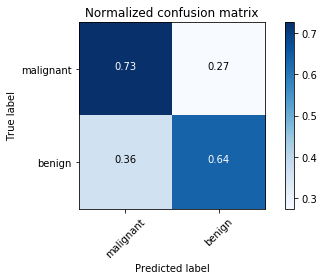

mattews corr : 0.3608545390548938
accuracy : 0.6914285714285714


In [298]:
# Fitting linear SVM 
import itertools    
print("Fitting Linear SVM ")
t0 = time()
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC(class_weight='balanced')
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)


# Looking for the best hyperparameters
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="accuracy", cv=5)
grid_lsvm.fit(X_forward, y_train)
print("Best Score: {}".format(grid_lsvm.best_score_))
print("Best params: {}".format(grid_lsvm.best_params_))
class_names = ["malignant", 'benign']
y_pred = grid_lsvm.predict(X_tst)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
from sklearn.metrics import matthews_corrcoef
print("mattews corr :",matthews_corrcoef(y_test, y_pred))
print("accuracy :",grid_lsvm.score(X_tst,y_test) )

# Decision trees

In [300]:
# Decision Tree
print("Decision Tree : training set")
t0 = time()
Tree = DecisionTreeClassifier(criterion="gini",random_state=0)
#Tree.fit(X_train,y_train)
p_grid = {'min_samples_leaf': range(2,100)}
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
# Nested CV with parameter optimization
clf3 = GridSearchCV(estimator=Tree, param_grid=p_grid, cv=inner_cv)
clf3.fit(X_forward,y_train)
nested_score = cross_val_score(clf3, X=X_forward, y=np.ravel(y_train), cv=outer_cv)
print(clf3.best_params_)
# Average accuracy
print("done in %0.3fs" % (time() - t0))
print("Average and std CV score : {0} +- {1}".format(nested_score.mean(), nested_score.std() ))
print("Score : ",clf3.score(X_tst,y_test))
y_pred = clf3.predict(X_tst)
print("mattews corr :",matthews_corrcoef(y_test, y_pred))

Decision Tree : training set
{'min_samples_leaf': 2}
done in 5.676s
Average and std CV score : 0.7211225806451613 +- 0.016851020095288622
Score :  0.6685714285714286
mattews corr : 0.3097055126481111


## Bagging

In [301]:
# Bagging
print("Decision Tree with Bagging : training set")
p_grid_tree = {'min_samples_leaf': [2,3,4,5,6,10],'min_samples_split': [2,3,4,5,6]} 
grid_tree = GridSearchCV(estimator=Tree, param_grid=p_grid_tree, scoring="precision", cv=5)
grid_tree.fit(X_forward, y_train)
Tree2 = DecisionTreeClassifier(criterion="gini", min_samples_leaf=grid_tree.best_params_['min_samples_leaf'],  random_state=0)
p_grid_bagging = {'n_estimators': [500,1000]}      
bag=BaggingClassifier(base_estimator=Tree2, random_state=0, max_samples=0.5)

inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
clf_Tree = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, cv=inner_cv, scoring="precision")
nested_score = cross_val_score(clf_Tree, X=X_forward, y=np.ravel(y_train),scoring="accuracy", cv=outer_cv)
clf_Tree.fit(X_forward,y_train)
print("Average and std Cv score : {0} +- {1}".format(nested_score.mean(), nested_score.std() ))

grid_bag = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, scoring="accuracy", cv=5)
grid_bag.fit(X_forward, y_train)
print("Best Score: {}".format(grid_bag.best_score_))
print("Best params: {}".format(grid_bag.best_params_))
print("Score : ",grid_bag.score(X_tst,y_test))
y_pred = grid_bag.predict(X_tst)
print("mattews corr :",matthews_corrcoef(y_test, y_pred))

Decision Tree with Bagging : training set
Average and std Cv score : 0.7564774193548387 +- 0.025563749047207353
Best Score: 0.7451923076923077
Best params: {'n_estimators': 500}
Score :  0.7142857142857143
mattews corr : 0.42792535689679917


## Random forests

In [302]:
# Random Forest
t0 = time()
print("Random Forest : training set")
RF=RandomForestClassifier(criterion="gini", random_state=0)
p_grid_RF = {'n_estimators': [6,10,20,30,50,100], 'min_samples_leaf': [2,4,6], 'max_features': ['sqrt','log2']}
rf = GridSearchCV(estimator=RF, param_grid=p_grid_RF)
rf.fit(X_forward,y_train)
print("done in %0.3fs" % (time() - t0))
print(rf.best_params_)
print("Score : ",rf.score(X_tst,y_test))
y_pred = rf.predict(X_tst)
print("mattews corr :",matthews_corrcoef(y_test, y_pred))

Random Forest : training set
done in 5.576s
{'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}
Score :  0.6742857142857143
mattews corr : 0.3310750787531568


In [303]:
### submission for kaggle
i=0
df_submission = pd.read_csv('data/test.csv')
for Id in df_submission['ImageId']:
    value = y[i] 
    df_submission.loc[df_submission['ImageId'] == Id, 'Malignant'] = value
    i=i+1
    
df_submission['Malignant'] = df_submission['Malignant'].astype(int) # This line is mandatory to be sure to have integer
print(df_submission.head(3))
df_submission.to_csv('data/11066.csv', index=None, sep=',', mode='w')

     ImageId  Malignant
0  IM_000788          0
1  IM_000640          0
2  IM_000889          1
